In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot  as plt
import torch.nn.functional as F
from torchvision.datasets import DatasetFolder
import cv2

device  = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!git clone https://github.com/skokalj/RowanDLclassNEA.git

Cloning into 'RowanDLclassNEA'...
remote: Enumerating objects: 1833, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1833 (delta 1), reused 5 (delta 0), pack-reused 1826
Receiving objects: 100% (1833/1833), 57.56 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [12]:
from torchvision import transforms
import PIL.Image


def load_image(img_path:str):    
        np_img = cv2.imread(img_path)
        return PIL.Image.fromarray(np_img)

dset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',))

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

In [5]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)


In [6]:
data, label = next(iter(trainloader))

data.shape

torch.Size([16, 3, 224, 224])

In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1)
    
    def forward(self, x):
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [8]:
import torch
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = Autoencoder().to(device=device)
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9)

N_EPOCHS = 50
tr_loss_hist = []
val_loss_hist = []

for epoch in range(N_EPOCHS):

    train_loss = 0.0
    autoencoder.train()
    
    for inputs, _ in trainloader:
        inputs = inputs.to(device)
        
        optimizer.zero_grad()

        outputs = autoencoder(inputs)
        resize_transform = transforms.Resize((224, 224))
        outputs = resize_transform(outputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    autoencoder.eval()
    
    for inputs, _ in valloader:
        inputs = inputs.to(device)

        outputs = autoencoder(inputs)
        resize_transform = transforms.Resize((224, 224))
        outputs = resize_transform(outputs)
        loss = criterion(outputs, inputs)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
        epoch, train_loss / len(trainloader), val_loss / len(valloader)))
    tr_loss_hist.append(train_loss / len(trainloader))
    val_loss_hist.append(val_loss / len(valloader))


/opt/pythonenvs/class_fall2023/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 Train Loss: 0.9518028545379639 Val Loss: 0.9658523609763697
Epoch: 1 Train Loss: 0.9460074162483215 Val Loss: 0.9590368004221665
Epoch: 2 Train Loss: 0.9405223806699117 Val Loss: 0.9493501045201954
Epoch: 3 Train Loss: 0.9354141402244568 Val Loss: 0.9451653675029152
Epoch: 4 Train Loss: 0.9305961275100708 Val Loss: 0.9413817054346988
Epoch: 5 Train Loss: 0.9261611262957256 Val Loss: 0.937158150108237
Epoch: 6 Train Loss: 0.9220320351918538 Val Loss: 0.9347476990599382
Epoch: 7 Train Loss: 0.9181701238950094 Val Loss: 0.9339352563807839
Epoch: 8 Train Loss: 0.9146210630734761 Val Loss: 0.9235319808909768
Epoch: 9 Train Loss: 0.9113225626945496 Val Loss: 0.9278211405402735
Epoch: 10 Train Loss: 0.9082182025909424 Val Loss: 0.9188628635908428
Epoch: 11 Train Loss: 0.9053869350751241 Val Loss: 0.914839473209883
Epoch: 12 Train Loss: 0.9027103447914123 Val Loss: 0.91742941266612
Epoch: 13 Train Loss: 0.9002487150828044 Val Loss: 0.9094880725208082
Epoch: 14 Train Loss: 0.8979640400

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50
(3, 224, 224)
(3, 217, 217)


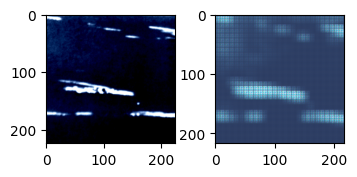

In [10]:
import matplotlib.pyplot as plt

autoencoder.eval()
originals = []
reconstructed = []

tset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata_split/Test', loader=load_image, extensions=('.bmp',), transform=transform)

test_loader = torch.utils.data.DataLoader(
    tset,
    batch_size=50,
    shuffle=True)

for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = autoencoder(inputs)

    inputs_np = inputs.cpu().detach().numpy()
    outputs_np = outputs.cpu().detach().numpy()

    originals.extend(inputs_np)
    reconstructed.extend(outputs_np)

originals = np.array(originals)
reconstructed = np.array(reconstructed)

#print(reconstructed[0])

num_images = len(originals[:50])


fig = plt.figure(figsize=(4,100))

print(num_images)

for i in range(1):
    fig.add_subplot(50,2,2*i+1)
    print(originals[0].shape)
    plt.imshow(originals[i].transpose((1, 2, 0)))  
    fig.add_subplot(50,2,2*i+2)
    print(reconstructed[0].shape)
    plt.imshow(reconstructed[i].transpose((1, 2, 0)))  


plt.show()


In [12]:
torch.save(autoencoder.state_dict(),"./AE_model.pt")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = Autoencoder().to(device=device)
autoencoder_s = autoencoder.load_state_dict(torch.load("./AE_model.pt",map_location=torch.device('cpu')))

In [14]:
import matplotlib.pyplot as plt

autoencoder_s.eval()
originals = []
reconstructed = []

tset = DatasetFolder(root=r'RowanDLclassNEA/NEUdata_split/Test', loader=load_image, extensions=('.bmp',), transform=transform)

test_loader = torch.utils.data.DataLoader(
    tset,
    batch_size=50,
    shuffle=True)

for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = autoencoder_s(inputs)

    inputs_np = inputs.cpu().detach().numpy()
    outputs_np = outputs.cpu().detach().numpy()

    originals.extend(inputs_np)
    reconstructed.extend(outputs_np)

originals = np.array(originals)
reconstructed = np.array(reconstructed)

#print(reconstructed[0])

num_images = len(originals[:50])


fig = plt.figure(figsize=(4,100))

print(num_images)

for i in range(1):
    fig.add_subplot(50,2,2*i+1)
    print(originals[0].shape)
    plt.imshow(originals[i].transpose((1, 2, 0)))  
    fig.add_subplot(50,2,2*i+2)
    print(reconstructed[0].shape)
    plt.imshow(reconstructed[i].transpose((1, 2, 0)))  


plt.show()


AttributeError: '_IncompatibleKeys' object has no attribute 'eval'